In [1]:
import rdflib
from rdflib import URIRef
from rdflib.namespace import OWL, RDF, RDFS,XSD, Namespace
import csv
from torch_geometric.data import HeteroData
import torch
import numpy as np
#import tensorflow as tf pytorch tensor != tf tensor

In [2]:
prefix = "https://dbpedia.org/ontology/"
possible_types = {}

In [3]:
def _store_dict(dict_path, list_to_store):
    with open(dict_path, 'wt') as file:
        writer = csv.writer(file, delimiter='\t')
        for idx, val in enumerate(list_to_store):
            writer.writerow([idx, val]) 

In [4]:
def get_relation_type(relation):
    r_split = relation.split("/")
    return r_split[len(r_split)-1]

In [5]:
ontology = rdflib.Graph()
ontology.parse('data/external/complete.nt', format='ttl')

<Graph identifier=N6608ab1a85a14cb8bfd0cedb322f7441 (<class 'rdflib.graph.Graph'>)>

In [6]:
ontology.bind("dbo", Namespace("http://dbpedia.org/ontology/"))
ontology.bind("dbr", Namespace("http://dbpedia.org/resource/"))
ontology.bind("rdfs", Namespace("http://www.w3.org/2000/01/rdf-schema#"))
ontology.bind("owl", Namespace("http://www.w3.org/2002/07/owl#"))
ontology.bind("rdf", Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#"))

In [7]:
def get_possible_types(subj_type, obj_type):
    if (subj_type,obj_type) not in possible_types:
        q = "SELECT DISTINCT ?property WHERE {"+\
        "{ ?property rdfs:domain dbo:"+subj_type+". ?property rdfs:range dbo:"+obj_type+\
        " .} UNION {dbo:"+subj_type +" rdfs:subClassOf ?superclass. dbo:"+obj_type +" rdfs:subClassOf  ?superclass2 ."+\
        "  ?property rdfs:domain ?superclass . ?property rdfs:range ?superclass2 "+\
        "} }"
        result = ontology.query(q)
        results = []
        for res in result:
            results.append(str(res[0]))
        
        q2 = "SELECT DISTINCT ?property WHERE {"+\
        "{dbo:"+subj_type +" rdfs:subClassOf ?superclass. "+\
        " ?property rdfs:domain ?superclass . ?property rdfs:range dbo:"+obj_type+\
        " .} UNION {dbo:"+obj_type +" rdfs:subClassOf  ?superclass2 . ?property rdfs:domain dbo:"+\
        subj_type+" . ?property rdfs:range ?superclass2}}"
        
        result = ontology.query(q2)
        for res in result:
            results.append(str(res[0]))
        
        possible_types[(subj_type,obj_type)] = results
        return results
    return possible_types[(subj_type,obj_type)]

In [8]:
entities_and_type = {}
relations = []
triples = []
triple_properties=[]
# Process the Knowledge Graph
g = rdflib.Graph()
g.parse('data/external/complete.nt', format='nt')
total = []
for s, p, o in g:
    total.append(str(s)+", "+ str(p) + ", "+ str(o))

    if str(p) != "http://www.w3.org/1999/02/22-rdf-syntax-ns#type":
        if not str(s) in entities_and_type.keys():
            entities_and_type[(str(s))] =[]
        if not str(p) in relations:
            relations.append(str(p))

        if str(o).find('^^') == -1:
            if not str(o) in entities_and_type.keys():
                entities_and_type[str(o)]=[]
            triples.append((s,p,o))
        else:
            triple_properties.append((str(s),str(p),str(o)))
        
    else:
        if str(s) not in entities_and_type.keys():
            entities_and_type[str(s)] =[]
        
        split_o = str(o).split('/')
        entities_and_type[str(s)].append(split_o[len(split_o)-1])
for e in entities_and_type:
    entities_and_type[e].sort()

In [9]:
def disambiguate_multiple_types(s,p,o): 
    
    for subtype_subj in entities_and_type[str(s)]:

        if len(entities_and_type[str(o)]) > 1:
            for subtype_obj in entities_and_type[str(o)]:
                possible_rels = get_possible_types( subtype_subj, subtype_obj)
                if len(possible_rels) == 0:
                    return ("","")    
                for rel in possible_rels:
                    if rel == p:
                        return (subtype_subj, subtype_obj)
        else:
            possible_rels = get_possible_types( subtype_subj, entities_and_type[str(o)][0])
            if len(possible_rels) == 0:
                    return ("","")    
            for rel in possible_rels:
                if rel == p:
                    return (subtype_subj, subtype_obj)
        
    return ("","")    

In [10]:
new_triples=[]
added_types = []
triples.sort()
for s,p,o in triples:
    if len(entities_and_type[str(s)]) > 1:
        new_subj_type, new_obj_type = disambiguate_multiple_types(s,p,o)
        if(new_subj_type, new_obj_type) == ("",""):
            continue
        #print("news", new_subj_type, "newo", new_obj_type, "sub", s, "obj", o)
        if new_subj_type != "" and new_obj_type != "":
            if s not in added_types:
                new_triples.append((s, "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",prefix+ new_subj_type[0] ))
                added_types.append(s)
            if o not in added_types:
                new_triples.append((o, "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",prefix+ new_obj_type[0] ))
                added_types.append(o)
            new_triples.append((new_subj_type, p, new_obj_type))
    else:  
        if s not in added_types:
            new_triples.append((s, "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",prefix+entities_and_type[str(s)][0] ))
            added_types.append(s)
        if o not in added_types:
            new_triples.append((o, "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",prefix+entities_and_type[str(o)][0] ))
            added_types.append(o)
        new_triples.append((s, p, o))

new_triples.sort()

In [11]:
entity_types_count = {}
entities = []
for entity in entities_and_type.keys():
    tipo = entities_and_type[entity][0]
    if tipo != "":
        entity_types_count[tipo] = entity_types_count.get(tipo, 0)+1
        entities.append(entity)

#_store_dict("entities.dict", entities)
#_store_dict("relations.dict", relations)

In [12]:
subject_dict = {}
object_dict = {}

index_dict = {t:{'count': 0} for t in entity_types_count.keys()}
new_triples.sort()
for triple in new_triples:
    s = str(triple[0])
    p = str(triple[1])
    o = str(triple[2])

    if s in entities and o in entities:
        p_type = get_relation_type(p)
        s_type = entities_and_type[s][0]
        o_type = entities_and_type[o][0]

        if(s_type != "" and o_type != ""):
            key_t = (s_type, p_type, o_type)
            
            if key_t not in subject_dict.keys():
                subject_dict[key_t] = []
                object_dict[key_t] = []
                
            if str(s) not in index_dict[s_type]:
                index_dict[s_type][str(s)] = index_dict[s_type]['count']
                index_dict[s_type]['count'] = index_dict[s_type]['count']+1
            s_index = index_dict[s_type][str(s)]
                
            if str(o) not in index_dict[o_type]:
                index_dict[o_type][str(o)] = index_dict[o_type]['count']
                index_dict[o_type]['count'] = index_dict[o_type]['count']+1
            o_index = index_dict[o_type][str(o)]
                
            subject_dict[key_t].append(s_index)
            object_dict[key_t].append(o_index)
         
        #data[s_type, p_type, o_type].edge_index[0].append(entities.index(str(s)))
        #data[s_type, p_type, o_type].edge_index[1].append(entities.index(str(o)))

In [68]:
data = HeteroData()
types = list(entity_types_count.keys())
for t in types:
    data[t].x = torch.Tensor([[1] for i in range(entity_types_count[t])])

In [70]:
for triple in subject_dict.keys():
    lol = [subject_dict[triple], object_dict[triple]]
    if len(lol[0]) > 10:
        data[triple[0], triple[1], triple[2]].edge_index = torch.Tensor(lol).long()

In [71]:
edge_types = list(data.edge_index_dict.keys())

In [72]:
from torch_geometric.utils import remove_self_loops, remove_isolated_nodes

for edge_type in data.edge_index_dict.keys():
    if edge_type[0] == edge_type[2]:
        new_edge_index = remove_self_loops(data[edge_type].edge_index)[0]
        data[edge_type].edge_index = new_edge_index
    new_edge_index = remove_isolated_nodes(data[edge_type].edge_index)[0]
    data[edge_type].edge_index = new_edge_index

In [74]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=4, out_channels=2)
model = to_hetero(model, data.metadata(), aggr='sum')

In [75]:
from torch_geometric.transforms import RandomLinkSplit

link_split = RandomLinkSplit(num_val=0.0,
                             num_test=0.25,
                             edge_types=edge_types,
                             rev_edge_types=[None]*len(edge_types))
train_link, val_link, test_link = link_split(data)

In [76]:
with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict,data.edge_index_dict)

In [77]:
weight_decay=5e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=weight_decay)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay = weight_decay)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, weight_decay = weight_decay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=weight_decay)
criterion =  torch.nn.BCEWithLogitsLoss() #change loss function

def train_hetlinkpre():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(train_link.x_dict, train_link.edge_index_dict)  # Perform a single forward pass.
    preds = torch.Tensor()
    edge_labels = torch.Tensor()
    ### LINK PREDICTION ACTS HERE ###
    for edge_t in edge_types:
        #Compute link embedding for each edge type
        #for src in train_link[edge_t].edge_label_index[0]:
        out_src = out[edge_t[0]][train_link[edge_t].edge_label_index[0]]#embedding src nodes
        out_dst = out[edge_t[2]][train_link[edge_t].edge_label_index[1]] #embedding dst nodes
        
        # LINK EMBEDDING #
        # 1 - Dot Product
        out_sim = out_src * out_dst #dotproduct
        pred = torch.sum(out_sim, dim=-1)
        
        preds = torch.cat((preds,pred),-1)
        edge_labels = torch.cat((edge_labels,train_link[edge_t].edge_label.type_as(pred)),-1)
    
        
    #compute loss function based on all edge types
    loss = criterion(preds, edge_labels)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

In [78]:
from sklearn.metrics import roc_auc_score

def test_hetlinkpre(test_link):
    model.eval()
    out = model(test_link.x_dict, test_link.edge_index_dict)
    
    ### LINK PREDICTION ACTS HERE ###
    
    hs = torch.Tensor()
    edge_labels = np.array([])
    ### LINK PREDICTION ACTS HERE ###
    for edge_t in edge_types:
        #Compute link embedding for each edge type
        #for src in train_link[edge_t].edge_label_index[0]:
        out_src = out[edge_t[0]][test_link[edge_t].edge_label_index[0]]#embedding src nodes
        out_dst = out[edge_t[2]][test_link[edge_t].edge_label_index[1]] #embedding dst nodes
        
        # LINK EMBEDDING #
        # 1 - Dot Product
        out_sim = out_src * out_dst #dotproduct
        h = torch.sum(out_sim, dim=-1)
        
        hs = torch.cat((hs,h),-1)
        edge_labels = np.concatenate((edge_labels,test_link[edge_t].edge_label.cpu().detach().numpy()))
    
    
    pred_cont = torch.sigmoid(hs).cpu().detach().numpy()
    
    # EVALUATION
    test_roc_score = roc_auc_score(edge_labels, pred_cont) #comput AUROC score for test set
    
    return test_roc_score

In [79]:
perf_train = []
perf_test = []
num_epochs = 200
for epoch in range(num_epochs):
    loss = train_hetlinkpre()
    roc_train = test_hetlinkpre(train_link)
    roc_test = test_hetlinkpre(test_link)
    perf_train.append(roc_train)
    perf_test.append(roc_test)
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [80]:
roc_train = test_hetlinkpre(train_link)
roc_test = test_hetlinkpre(test_link)
print(f'Train AUROC: {roc_train:.4f}\nTest AUROC: {roc_test:.4f}')

Train AUROC: 0.7361
Test AUROC: 0.7190


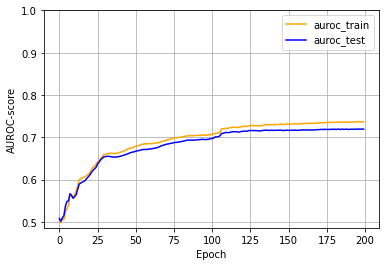

In [81]:
import matplotlib.pyplot as plt

x = range(num_epochs)
plt.clf()
plt.plot(x, perf_train, color='orange', label='auroc_train')
plt.plot(x, perf_test, color='blue', label='auroc_test')
plt.xlabel('Epoch')
plt.ylabel('AUROC-score')
plt.legend()
plt.ylim(top=1)
plt.grid()
plt.show()
#plt.clf()